In [12]:
import networkx as nx
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import math
import time
import statistics

In [2]:
'''
Network class that uses networkx graph to represent the network
local variables:
n: # of nodes
m: # of links
graph: graph representation of the network
BANDWIDTH: bandwidth of each link if all links share the same bandwidth
DELAY_LOW: lower bound of delay time for links
DELAY_HIGH: higher bound of delay time for links
'''

class Network:
    def __init__(self, n = 0, m = 0, input_file = None, BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 25):
        self.BANDWIDTH = BANDWIDTH
        self.DELAY_LOW = DELAY_LOW
        self.DELAY_HIGH = DELAY_HIGH
        
        if (input_file):
            self.graph = self.build_network_from_input_file(input_file)
        else:
            # build_random_network(self, n, m)
            pass
        
    def build_network_from_input_file(self, input_file):
        with open(input_file) as f:
            self.n = int(next(f))
            G = nx.Graph()
            
            # add nodes to the graph
            G.add_nodes_from([0, self.n - 1])
            
            # add edges to the graph
            
            # get each row from input file
            for _ in range(self.n):
                cur_row = [int(x) for x in next(f).split()]
                u = cur_row[0]
                for v in cur_row[1:]:
                    G.add_edge(u, v, bandwidth = self.BANDWIDTH, \
                               delay = random.randint(self.DELAY_LOW, self.DELAY_HIGH), \
                               residual_bandwidth = self.BANDWIDTH)
                    
            return G

In [3]:
class Flow:
    def __init__(self, src, des, bandwidth_request, delay_request):
        self.bandwidth_request = bandwidth_request
        self.delay_request = delay_request
        self.src = src
        self.des = des

    def __str__(self):
        return str((self.src, self.des, self.bandwidth_request, self.delay_request))
  
    def __repr__(self):
        return str((self.src, self.des, self.bandwidth_request, self.delay_request))

    
    @classmethod
    def generate_random_flow(self, network, BANDWIDTH_LOW = 1, BANDWIDTH_HIGH = 5, DELAY_LOW = 0, DELAY_HIGH = 200):
        number_of_nodes = network.graph.number_of_nodes()
        src = random.randint(0, number_of_nodes - 1)
        des = src
        while (des == src):
            des = random.randint(0, number_of_nodes - 1)
        return Flow(src, des, \
                    random.randint(BANDWIDTH_LOW, BANDWIDTH_HIGH), \
                    random.randint(DELAY_LOW, DELAY_HIGH))
    
    @classmethod
    def generate_random_flows(self, n, network, BANDWIDTH_LOW = 1, BANDWIDTH_HIGH = 5, DELAY_LOW = 0, DELAY_HIGH = 200):
        flows = []
        for _ in range(n):
            flows.append(Flow.generate_random_flow(network, BANDWIDTH_LOW = BANDWIDTH_LOW, BANDWIDTH_HIGH = BANDWIDTH_HIGH, DELAY_LOW = DELAY_LOW, DELAY_HIGH = DELAY_HIGH))
        return flows

In [4]:
def pd_mcr(network, flows):
    
    # Initialize x(e) := 0, ∀e∈E
    for e in network.graph.edges():
        u, v = e
        network.graph[u][v]['x'] = 0
    
    num_of_accepted = 0
    for flow in flows:
        if (route(network, flow)):
            num_of_accepted += 1
    
    success_rate = num_of_accepted / len(flows)
#     print("success rate: " + str(success_rate))
    return success_rate

In [5]:
def route(network, flow):
#     print("trying to route: " + str(flow))
    path = mcr_bellman(network.graph, flow)
    G = network.graph
    n = network.graph.number_of_nodes()
    if path:
        for e in path:
            u, v = e
            G[u][v]['residual_bandwidth'] = G[u][v]['residual_bandwidth'] - flow.bandwidth_request
            G[u][v]['x'] = G[u][v]['x'] * math.exp(math.log(1 + n) \
                                                   * flow.bandwidth_request / G[u][v]['bandwidth']) \
                            + 1 / n * (math.exp(math.log(1 + n) \
                                                   * flow.bandwidth_request / G[u][v]['bandwidth']) - 1)
            
#             print(G[u][v]['x'])
#         print("--success, by path: ", path)
        return True
    
    else:
#         print("--fail to route!")
        return False

In [6]:
'''
flow: src, des, bandwidth_request, delay_request(c2 \in Z), c1 = 1
network: (G)  G[u][v]['delay'] -> w2; G[u][v]['x'] -> w1
'''
def mcr_bellman(G, flow):
    # !!! note this is undirected graph, so need to relax twice for both directions
    def relax(u, v, k):
        kk = k + G[u][v]['delay']
        if kk <= c2 and dist[v][kk] > dist[u][k] + G[u][v]['x']:
            dist[v][kk] = dist[u][k] + G[u][v]['x']
            par[v][kk] = u
            
    def construct_path():
        # check if the result is feasible, if not, return null
        path_exist = False
        for k in range(c2 + 1):
            if dist[des][k] <= c1:
                path_exist = True
                break
        
        if not path_exist:
            return None
                
        
        # path is feasible, reconstruct the path from end to start
        path = []
        curNode = des
        pathNodes = {curNode}
        
        while curNode != src:
            for k in range(c2 + 1):
#                 if src == 2 and des == 11:
#                     print(k, curNode, par[curNode][k])
                if par[curNode][k] != None and par[curNode][k] not in pathNodes:
                    path.append((par[curNode][k], curNode))
                    curNode = par[curNode][k]
                    pathNodes.add(curNode)
                    break
        
        # reverse list
        path.reverse()
        return path

            
#     G = network.graph
    src = flow.src
    des = flow.des
    c1 = 1
    c2 = flow.delay_request
    n = G.number_of_nodes()
    
    # Initialization
    dist = [[math.inf] * (c2 + 1) for _ in range(n)]
    par = [[None] * (c2 + 1) for _ in range(n)]
    for i in range(c2 + 1):
        dist[src][i] = 0
                
    # Bellman-Ford
    for j in range(n):
        for k in range(c2 + 1):
            for e in G.edges:
                u, v = e
                relax(u, v, k)
                relax(v, u, k)
    
    
    # CONSTRUCT PATH
    path = construct_path()

    return path

In [7]:
def e2e(network, flows):
    num_of_accepted = 0
    for flow in flows:
        if (e2e_route(network, flow)):
            num_of_accepted += 1
            
    success_rate = num_of_accepted / len(flows)
#     print("success rate: " + str(success_rate))
    return success_rate

In [8]:
def e2e_route(network, flow):
#     print("trying to route: " + str(flow))
    G = network.graph
    n = network.graph.number_of_nodes()
    
    # create subgraph for current flow
    valid_edges = []
    for e in G.edges():
        u, v = e
        if G[u][v]['residual_bandwidth'] >= flow.bandwidth_request:
            valid_edges.append(e)
    
    curG = G.edge_subgraph(valid_edges)
    
    max_bandwidth_utilization = 0
    
    for e in curG.edges():
        u, v = e;
        G[u][v]['bandwidth_utilization'] = flow.bandwidth_request / G[u][v]['residual_bandwidth']
        max_bandwidth_utilization = max(max_bandwidth_utilization, G[u][v]['bandwidth_utilization'])
    
    
    path = e2e_mcr_bellman(curG, flow, max_bandwidth_utilization, n)
    
    if path:
        for e in path:
            u, v = e
            G[u][v]['residual_bandwidth'] = G[u][v]['residual_bandwidth'] - flow.bandwidth_request
#         print("--success, by path: ", path)
        return True
    
    else:
#         print("--fail to route!")
        return False

In [9]:
'''
flow: src, des, bandwidth_request, delay_request(c2 \in Z), c1 = 1
network: (G)  G[u][v]['delay'] -> w2; G[u][v]['x'] -> w1
'''
def e2e_mcr_bellman(G, flow, max_bandwidth_utilization, n):
    
    
    # !!! note this is undirected graph, so need to relax twice for both directions
    def relax(u, v, k):
        kk = k + G[u][v]['delay']
        if kk <= c2 and dist[v][kk] > dist[u][k] + G[u][v]['bandwidth_utilization']:
            dist[v][kk] = dist[u][k] + G[u][v]['bandwidth_utilization']
            par[v][kk] = u
            
    def construct_path():
        # check if the result is feasible, if not, return null
        path_exist = False
        for k in range(c2 + 1):
            if dist[des][k] <= c1:
                path_exist = True
                break
        
        if not path_exist:
            return None
                
        
        # path is feasible, reconstruct the path from end to start
        path = []
        curNode = des
        pathNodes = {curNode}
        
        while curNode != src:
            for k in range(c2 + 1):
#                 if src == 2 and des == 11:
#                     print(k, curNode, par[curNode][k])
                if par[curNode][k] != None and par[curNode][k] not in pathNodes:
                    path.append((par[curNode][k], curNode))
                    curNode = par[curNode][k]
                    pathNodes.add(curNode)
                    break
        
        # reverse list
        path.reverse()
        return path

            
#     G = network.graph
#     n = G.number_of_nodes()
    src = flow.src
    des = flow.des
    c1 = max_bandwidth_utilization * n
    c2 = flow.delay_request
    
    
    # Initialization
    dist = [[math.inf] * (c2 + 1) for _ in range(n)]
    par = [[None] * (c2 + 1) for _ in range(n)]
    for i in range(c2 + 1):
        dist[src][i] = 0
                
    # Bellman-Ford
    for j in range(n):
        for k in range(c2 + 1):
            for e in G.edges:
                u, v = e
                relax(u, v, k)
                relax(v, u, k)
    
    
    # CONSTRUCT PATH
    path = construct_path()

    return path

In [27]:
x = []
acc_rate_pd_mcr = []
acc_rate_e2e = []
time_pd_mcr = []
time_e2e = []

# avg_bw_utilization_pd_mcr = []
# sd_bw_utilization_pd_mcr = []
# avg_bw_utilization_e2e = []
# sd_bw_utilization_e2e = []

for num_of_flow in range(1,201, 10):
    acc_rate_1 = []
    acc_rate_2 = []
    time_1 = []
    time_2 = []
#     avg_bw_utilization_1 = []
#     sd_bw_utilization_1 = []
#     avg_bw_utilization_2 = []
#     sd_bw_utilization_2 = []
    
    print("Testing: ", num_of_flow, "flows")
    for _ in range(5):
        network = Network(input_file = "net14.txt", BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 5)
        flows = Flow.generate_random_flows(num_of_flow, network, BANDWIDTH_LOW = 3, BANDWIDTH_HIGH = 5, DELAY_LOW = 0, DELAY_HIGH = 200)
        
        network = Network(input_file = "net14.txt", BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 5)
        
        start_1 = time.time()
        acc_rate_1.append(pd_mcr(network, flows))
        time_1.append(time.time() - start_1)
#         avg, sd = calc_bw_utilization(network)
#         avg_bw_utilization_1.append(avg)
#         sd_bw_utilization_1.append(sd)
        
        
        
        network = Network(input_file = "net14.txt", BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 5)
        
        start_2 = time.time()
        acc_rate_2.append(e2e(network, flows))
        time_2.append(time.time() - start_2)
#         avg, sd = calc_bw_utilization(network)
#         avg_bw_utilization_2.append(avg)
#         sd_bw_utilization_2.append(sd)
    
    print("pd_mcr: ", sum(acc_rate_1) / len(acc_rate_1))
    print("e2e: ", sum(acc_rate_2) / len(acc_rate_2))
    
    x.append(num_of_flow)
    
    acc_rate_pd_mcr.append(statistics.mean(acc_rate_1))
    acc_rate_e2e.append(statistics.mean(acc_rate_2))
    
    time_pd_mcr.append(statistics.mean(time_1))
    time_e2e.append(statistics.mean(time_2))
    
    
#     avg_bw_utilization_pd_mcr.append(sum(avg_bw_utilization_1)/len(avg_bw_utilization_1))
#     avg_bw_utilization_e2e.append(sum(avg_bw_utilization_2)/len(avg_bw_utilization_2))
    
    
#     sd_bw_utilization_pd_mcr.append(sum(sd_bw_utilization_1)/len(sd_bw_utilization_1))
#     sd_bw_utilization_e2e.append(sum(sd_bw_utilization_2)/len(sd_bw_utilization_2))

Testing:  1 flows
pd_mcr:  1.0
e2e:  1.0
Testing:  11 flows
pd_mcr:  0.9636363636363636
e2e:  0.9272727272727274
Testing:  21 flows
pd_mcr:  0.9047619047619048
e2e:  0.7238095238095239
Testing:  31 flows
pd_mcr:  0.6580645161290323
e2e:  0.4387096774193548
Testing:  41 flows
pd_mcr:  0.6097560975609757
e2e:  0.4439024390243902
Testing:  51 flows
pd_mcr:  0.5058823529411764
e2e:  0.3098039215686274
Testing:  61 flows
pd_mcr:  0.4426229508196721
e2e:  0.31147540983606553
Testing:  71 flows
pd_mcr:  0.4507042253521127
e2e:  0.2788732394366197
Testing:  81 flows
pd_mcr:  0.3604938271604938
e2e:  0.22962962962962963
Testing:  91 flows
pd_mcr:  0.3604395604395604
e2e:  0.2197802197802198
Testing:  101 flows
pd_mcr:  0.3306930693069307
e2e:  0.22574257425742572
Testing:  111 flows
pd_mcr:  0.3081081081081081
e2e:  0.1963963963963964
Testing:  121 flows
pd_mcr:  0.2942148760330579
e2e:  0.16363636363636364
Testing:  131 flows
pd_mcr:  0.2595419847328244
e2e:  0.16641221374045803
Testing:  141 

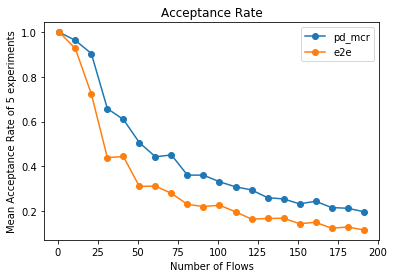

In [30]:
import matplotlib.pyplot as plt    
plt.xlabel("Number of Flows")
plt.ylabel("Mean Acceptance Rate of 5 experiments")
plt.title("Acceptance Rate")
plt.plot(x,acc_rate_pd_mcr,label='pd_mcr',marker='o')
plt.plot(x,acc_rate_e2e,label='e2e',marker='o')
plt.legend()
plt.savefig('net14_experiment_acc_rate' + str(time.time()) + '.pdf')
plt.show()


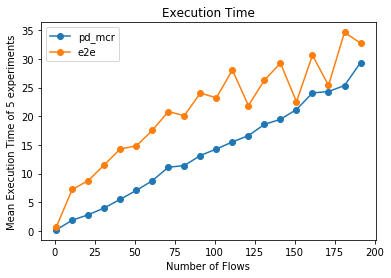

In [31]:
import matplotlib.pyplot as plt    
plt.xlabel("Number of Flows")
plt.ylabel("Mean Execution Time of 5 experiments")
plt.title("Execution Time")
plt.plot(x,time_pd_mcr,label='pd_mcr',marker='o')
plt.plot(x,time_e2e,label='e2e',marker='o')
plt.legend()
plt.savefig('net14_experiment_ext_time' + str(time.time()) + '.pdf')
plt.show()


In [ ]:
x = []
acc_rate_pd_mcr = []
acc_rate_e2e = []
time_pd_mcr = []
time_e2e = []

# avg_bw_utilization_pd_mcr = []
# sd_bw_utilization_pd_mcr = []
# avg_bw_utilization_e2e = []
# sd_bw_utilization_e2e = []

for num_of_flow in range(1,201,30):
    acc_rate_1 = []
    acc_rate_2 = []
    time_1 = []
    time_2 = []
#     avg_bw_utilization_1 = []
#     sd_bw_utilization_1 = []
#     avg_bw_utilization_2 = []
#     sd_bw_utilization_2 = []
    
    print("Testing: ", num_of_flow, "flows")
    for _ in range(2):
        network = Network(input_file = "net50.txt", BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 5)
        flows = Flow.generate_random_flows(num_of_flow, network, BANDWIDTH_LOW = 3, BANDWIDTH_HIGH = 5, DELAY_LOW = 0, DELAY_HIGH = 200)
        
        network = Network(input_file = "net50.txt", BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 5)
        
        start_1 = time.time()
        acc_rate_1.append(pd_mcr(network, flows))
        time_1.append(time.time() - start_1)
#         avg, sd = calc_bw_utilization(network)
#         avg_bw_utilization_1.append(avg)
#         sd_bw_utilization_1.append(sd)
        
        
        
        network = Network(input_file = "net50.txt", BANDWIDTH = 10, DELAY_LOW = 5, DELAY_HIGH = 5)
        
        start_2 = time.time()
        acc_rate_2.append(e2e(network, flows))
        time_2.append(time.time() - start_2)
#         avg, sd = calc_bw_utilization(network)
#         avg_bw_utilization_2.append(avg)
#         sd_bw_utilization_2.append(sd)
    
    print("pd_mcr: ", sum(acc_rate_1) / len(acc_rate_1))
    print("e2e: ", sum(acc_rate_2) / len(acc_rate_2))
    
    x.append(num_of_flow)
    
    acc_rate_pd_mcr.append(statistics.mean(acc_rate_1))
    acc_rate_e2e.append(statistics.mean(acc_rate_2))
    
    time_pd_mcr.append(statistics.mean(time_1))
    time_e2e.append(statistics.mean(time_2))
    
    
#     avg_bw_utilization_pd_mcr.append(sum(avg_bw_utilization_1)/len(avg_bw_utilization_1))
#     avg_bw_utilization_e2e.append(sum(avg_bw_utilization_2)/len(avg_bw_utilization_2))
    
    
#     sd_bw_utilization_pd_mcr.append(sum(sd_bw_utilization_1)/len(sd_bw_utilization_1))
#     sd_bw_utilization_e2e.append(sum(sd_bw_utilization_2)/len(sd_bw_utilization_2))

In [ ]:
import matplotlib.pyplot as plt    
plt.xlabel("Number of Flows")
plt.ylabel("Mean Acceptance Rate of 2 experiments")
plt.title("Acceptance Rate")
plt.plot(x,acc_rate_pd_mcr,label='pd_mcr')
plt.plot(x,acc_rate_e2e,label='e2e')
plt.legend()
plt.savefig('net50_experiment_acc_rate' + str(time.time()) + '.pdf')
plt.show()

In [ ]:
import matplotlib.pyplot as plt    
plt.xlabel("Number of Flows")
plt.ylabel("Mean Execution Time of 2 experiments")
plt.title("Execution Time")
plt.plot(x,time_pd_mcr,label='pd_mcr')
plt.plot(x,time_e2e,label='e2e')
plt.legend()
plt.savefig('net50_experiment_ext_time' + str(time.time()) + '.pdf')
plt.show()
